In [18]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [19]:

bag = rosbag.Bag('/home/uware/rosbags/static/translation/21h7_s_z_2-4-6-8-10_360_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4]

In [20]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [21]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,1.431183
1,5.901175,2.488261
2,6.011829,2.565347
3,6.135028,2.619042
4,6.241741,2.678635
...,...,...
1186,122.635822,0.943020
1187,127.622089,2.446235
1188,128.797093,1.618498
1189,131.869950,2.361452


<AxesSubplot:xlabel='relative_time'>

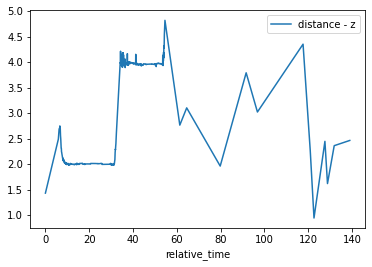

In [22]:
# initial graph
df.plot(x='relative_time', y=target)

In [23]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .01)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [24]:
# the amount of data points we are left with
len(x[peaks])

191

In [25]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

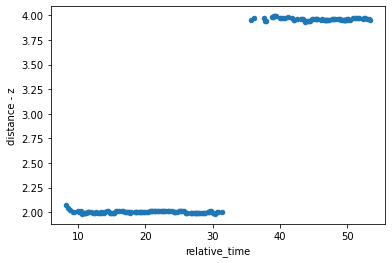

In [26]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [27]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
df_filtered_by_targets

,relative_time,distance - z,true_distance
33,8.233788,2.072874,2
42,8.574436,2.048344,2
48,8.812497,2.024697,2
62,9.359318,2.002416,2
66,9.508829,2.006791,2
...,...,...,...
1129,52.502074,3.969797,4
1132,52.612626,3.970560,4
1140,52.914584,3.961044,4
1147,53.187607,3.966000,4


In [28]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [29]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [30]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
33,8.233788,2.072874,2,-0.072874
42,8.574436,2.048344,2,-0.048344
697,35.774167,3.950455,4,0.049545
707,36.155301,3.976499,4,0.023501


In [31]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,119.0,-0.004140,0.011002,-0.072874,-0.011883,-0.002056,0.004159,0.016807
4,72.0,0.036113,0.012746,0.009640,0.028774,0.037486,0.043069,0.071031


In [32]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

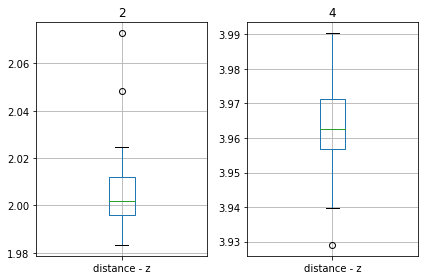

In [33]:
box_plotter(target)

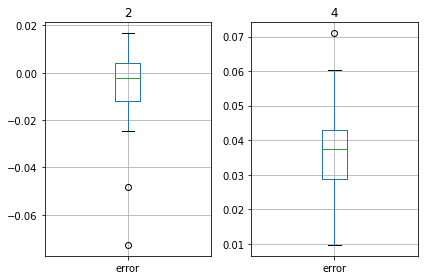

In [34]:
box_plotter('error')